In [1]:
import numpy as np
import pandas as pd
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import string
import warnings
from spacy.lang.char_classes import LIST_PUNCT
from collections import defaultdict

warnings.filterwarnings('ignore')

In [2]:
nlp = spacy.load("en_core_web_sm")
stopwords = nlp.Defaults.stop_words

raw_tweets_df = pd.read_csv("./data/tweets.csv")
raw_tweets_df['keyword'] = raw_tweets_df['keyword'].str.replace(r"%20", "_")

natural_disaster_keywords = ["avalanche", "bush_fires", "cyclone", "flood", "flooding", "floods", "flames", "forest_fire", "forest_fires", "drought", "dust_storm", 
                            "earthquake", "hail", "hailstorm", "heat_wave", "hurricane", "icestorm", "landslide", "lava", "lightning", "mudslide", "rainstorm", 
                            "sandstorm", "snowstorm",  "strong_wind", "storm", "thunder", "thunderstorm", "tornado", "twister", "typhoon", "tsunami", "violent_storm", 
                            "volcanic_activity", "volcano", "volcanic", "wildfire", "wildfires", "wild_fire", "wild_fires", "whirlwind", "windstorm"]

filtered_tweets_df = raw_tweets_df.copy()
filtered_tweets_df = filtered_tweets_df[filtered_tweets_df['keyword'].isin(natural_disaster_keywords)]

In [3]:
filtered_tweets_df['keyword'].unique()

array(['avalanche', 'bush_fires', 'cyclone', 'drought', 'dust_storm',
       'earthquake', 'flames', 'flood', 'flooding', 'floods',
       'forest_fire', 'forest_fires', 'hail', 'hailstorm', 'heat_wave',
       'hurricane', 'landslide', 'lava', 'lightning', 'mudslide',
       'rainstorm', 'sandstorm', 'snowstorm', 'storm', 'thunder',
       'thunderstorm', 'tornado', 'tsunami', 'twister', 'typhoon',
       'violent_storm', 'volcano', 'whirlwind', 'wild_fires', 'wildfire',
       'windstorm'], dtype=object)

In [4]:
# word_count
filtered_tweets_df['word_count'] = filtered_tweets_df['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
filtered_tweets_df['unique_word_count'] = filtered_tweets_df['text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
filtered_tweets_df['stop_word_count'] = filtered_tweets_df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in stopwords]))

# url_count
filtered_tweets_df['url_count'] = filtered_tweets_df['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
filtered_tweets_df['mean_word_length'] = filtered_tweets_df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
filtered_tweets_df['char_count'] = filtered_tweets_df['text'].apply(lambda x: len(str(x)))

# punctuation_count
filtered_tweets_df['punctuation_count'] = filtered_tweets_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
filtered_tweets_df['hashtag_count'] = filtered_tweets_df['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
filtered_tweets_df['mention_count'] = filtered_tweets_df['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

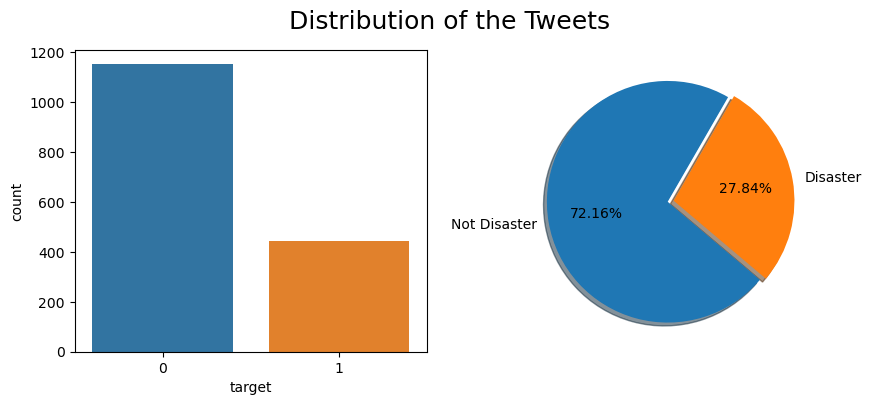

In [5]:
# Displaying target distribution.

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 4), dpi=100)
sns.countplot(filtered_tweets_df['target'], ax=axes[0])
axes[1].pie(filtered_tweets_df['target'].value_counts(),
            labels=['Not Disaster', 'Disaster'],
            autopct='%1.2f%%',
            shadow=True,
            explode=(0.05, 0),
            startangle=60)
fig.suptitle('Distribution of the Tweets', fontsize=18)
plt.show()

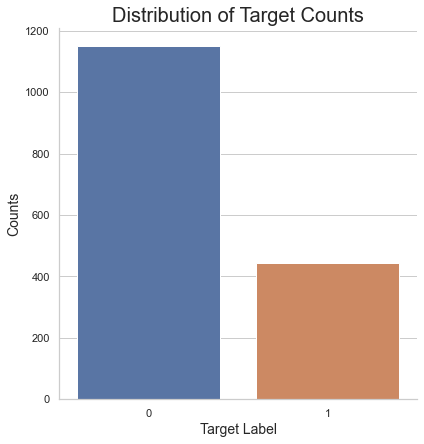

In [6]:
# counting the number of positive and negative tweets
sns.set(style="whitegrid", color_codes=True)
sns.catplot("target", data=filtered_tweets_df, kind="count", height=6)
plt.title("Distribution of Target Counts", size=20)
plt.xlabel("Target Label", size=14)
plt.ylabel("Counts", size=14)
plt.show()

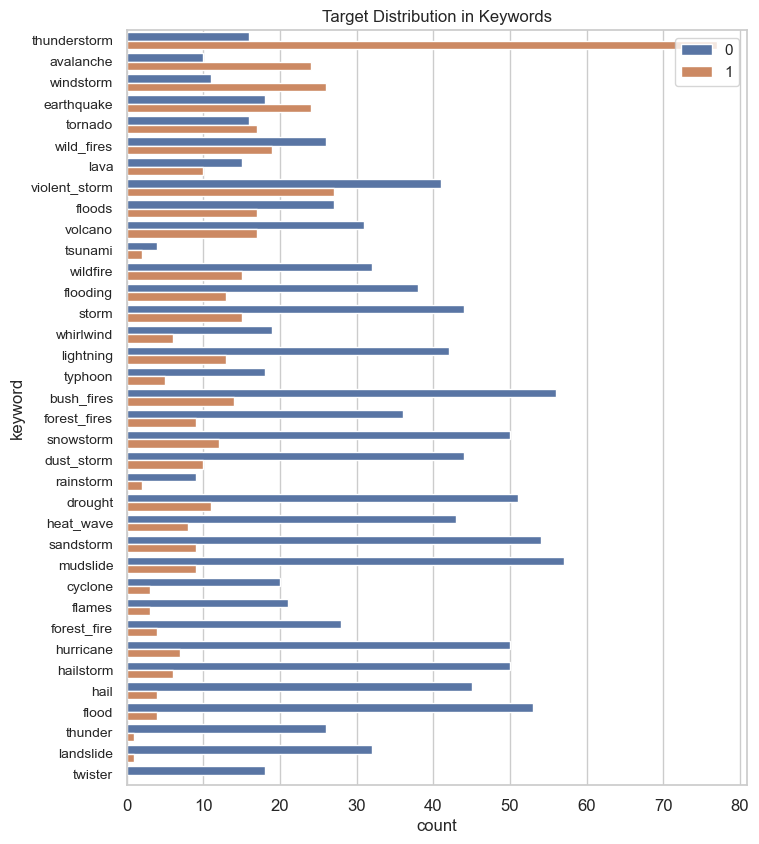

In [7]:
filtered_tweets_df['target_mean'] = filtered_tweets_df.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(8, 10), dpi=100)

sns.countplot(y=filtered_tweets_df.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=filtered_tweets_df.sort_values(by='target_mean', ascending=False)['target'])

plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=10)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')
plt.show()

filtered_tweets_df.drop(columns=['target_mean'], inplace=True)

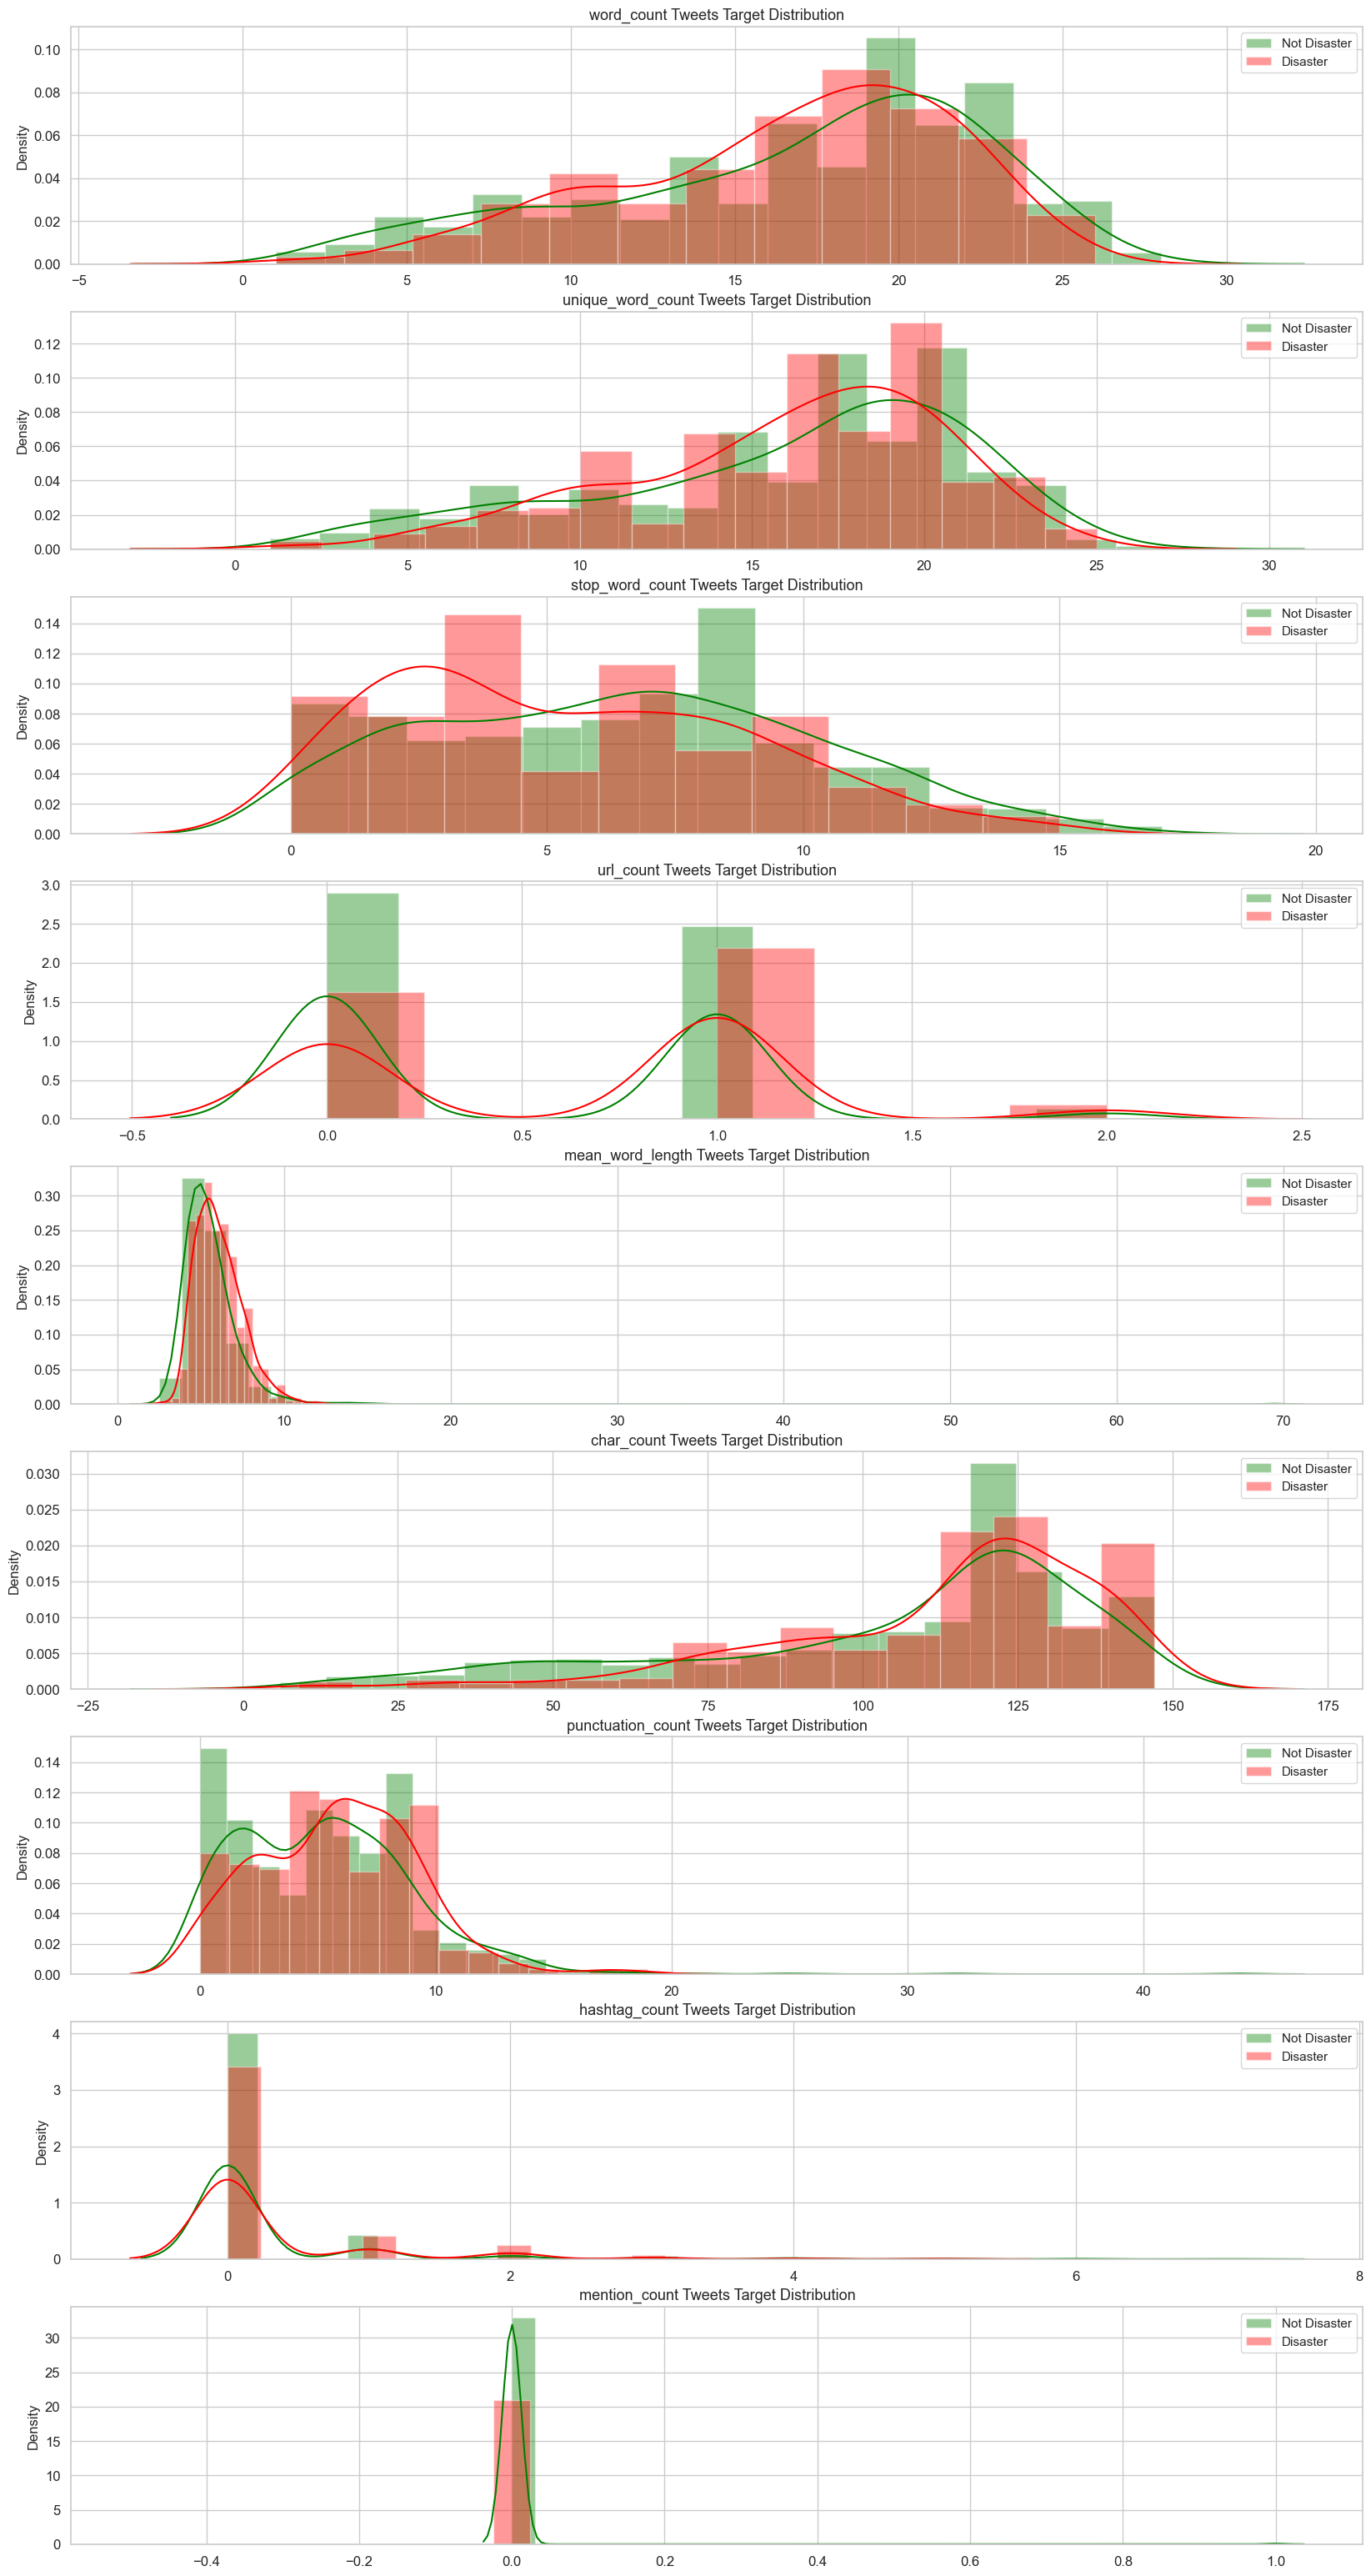

In [8]:
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
                'char_count', 'punctuation_count', 'hashtag_count', 'mention_count']
DISASTER_TWEETS = filtered_tweets_df['target'] == 1

fig, axes = plt.subplots(nrows=len(METAFEATURES), figsize=(20, 40), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.distplot(filtered_tweets_df.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[i], color='green')
    sns.distplot(filtered_tweets_df.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i], color='red')
    
    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', labelsize=12)
    axes[i].tick_params(axis='y', labelsize=12)
    axes[i].legend()    
    axes[i].set_title(f'{feature} Tweets Target Distribution', fontsize=13)

plt.show()

In [9]:
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in stopwords]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

N = 20

METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
                'char_count', 'punctuation_count', 'hashtag_count', 'mention_count']
DISASTER_TWEETS = filtered_tweets_df['target'] == 1

# Unigrams
disaster_unigrams = defaultdict(int)
nondisaster_unigrams = defaultdict(int)

for tweet in filtered_tweets_df[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet):
        disaster_unigrams[word] += 1
        
for tweet in filtered_tweets_df[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet):
        nondisaster_unigrams[word] += 1
        
df_disaster_unigrams = pd.DataFrame(sorted(disaster_unigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_unigrams = pd.DataFrame(sorted(nondisaster_unigrams.items(), key=lambda x: x[1])[::-1])

# Bigrams
disaster_bigrams = defaultdict(int)
nondisaster_bigrams = defaultdict(int)

for tweet in filtered_tweets_df[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        disaster_bigrams[word] += 1
        
for tweet in filtered_tweets_df[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        nondisaster_bigrams[word] += 1
        
df_disaster_bigrams = pd.DataFrame(sorted(disaster_bigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_bigrams = pd.DataFrame(sorted(nondisaster_bigrams.items(), key=lambda x: x[1])[::-1])

# Trigrams
disaster_trigrams = defaultdict(int)
nondisaster_trigrams = defaultdict(int)

for tweet in filtered_tweets_df[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=3):
        disaster_trigrams[word] += 1
        
for tweet in filtered_tweets_df[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=3):
        nondisaster_trigrams[word] += 1
        
df_disaster_trigrams = pd.DataFrame(sorted(disaster_trigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_trigrams = pd.DataFrame(sorted(nondisaster_trigrams.items(), key=lambda x: x[1])[::-1])

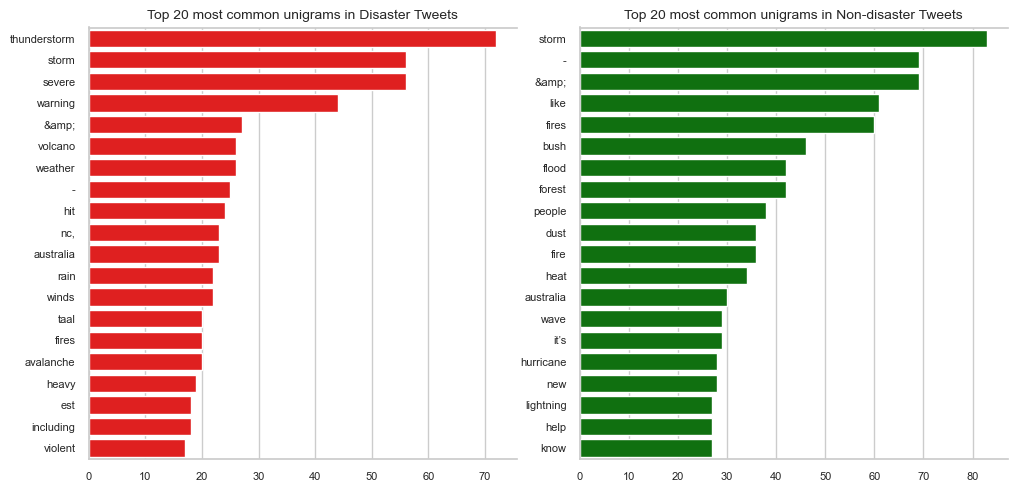

In [10]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5), dpi=100)
plt.tight_layout()

sns.barplot(y=df_disaster_unigrams[0].values[:N], x=df_disaster_unigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_nondisaster_unigrams[0].values[:N], x=df_nondisaster_unigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=8)
    axes[i].tick_params(axis='y', labelsize=8)

axes[0].set_title(f'Top {N} most common unigrams in Disaster Tweets', fontsize=10)
axes[1].set_title(f'Top {N} most common unigrams in Non-disaster Tweets', fontsize=10)

plt.show()

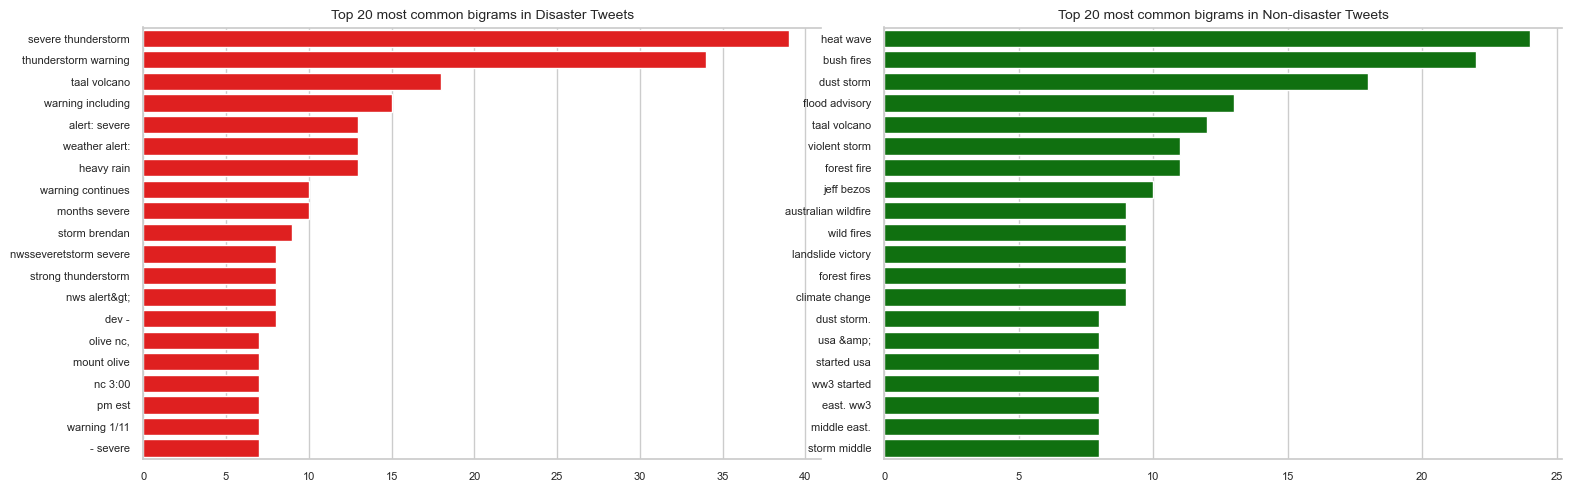

In [11]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5), dpi=100)
plt.tight_layout()

sns.barplot(y=df_disaster_bigrams[0].values[:N], x=df_disaster_bigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_nondisaster_bigrams[0].values[:N], x=df_nondisaster_bigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=8)
    axes[i].tick_params(axis='y', labelsize=8)

axes[0].set_title(f'Top {N} most common bigrams in Disaster Tweets', fontsize=10)
axes[1].set_title(f'Top {N} most common bigrams in Non-disaster Tweets', fontsize=10)

plt.show()

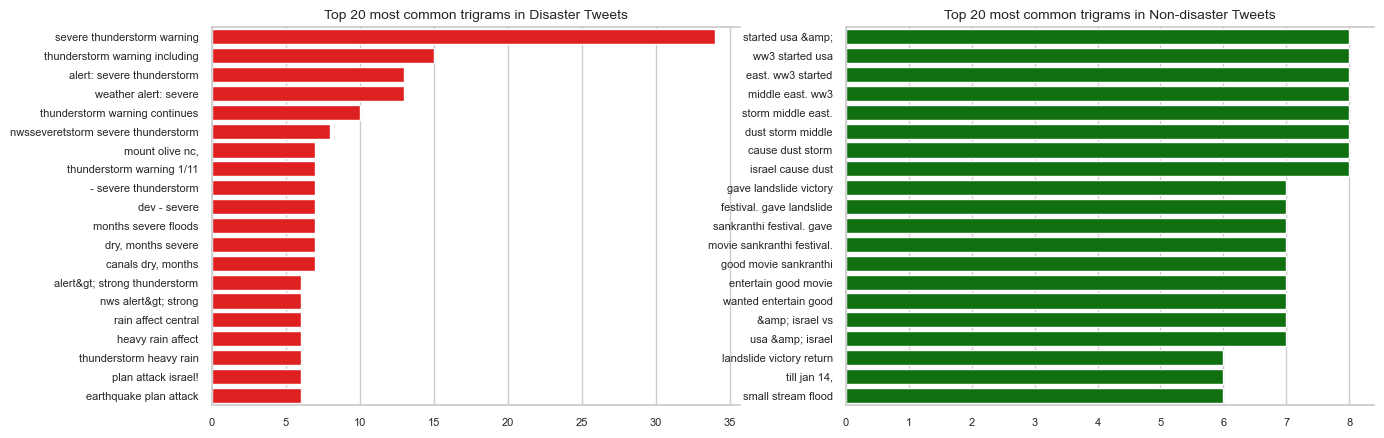

In [12]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5), dpi=100)

sns.barplot(y=df_disaster_trigrams[0].values[:N], x=df_disaster_trigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_nondisaster_trigrams[0].values[:N], x=df_nondisaster_trigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=8)
    axes[i].tick_params(axis='y', labelsize=8)

axes[0].set_title(f'Top {N} most common trigrams in Disaster Tweets', fontsize=10)
axes[1].set_title(f'Top {N} most common trigrams in Non-disaster Tweets', fontsize=10)

plt.show()

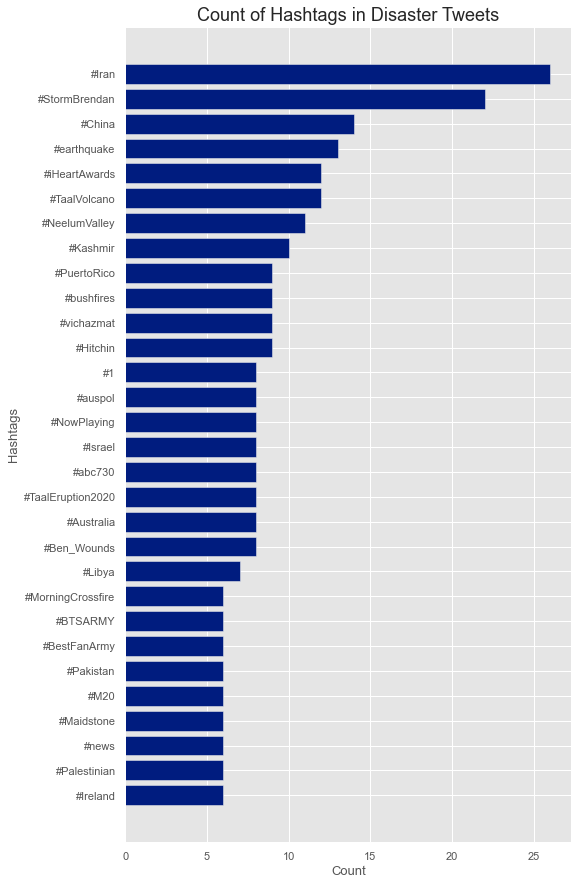

In [46]:
hashtag_list = []
for text in raw_tweets_df['text'].tolist():
    if bool(re.search(r"#\w+", text)):
        for tag in re.findall(r"#\w+", text):
            hashtag_list.append(tag)

# Count the number of occurrences of each word
word_counts = {}
for word in hashtag_list:
  if word in word_counts:
    word_counts[word] += 1
  else:
    word_counts[word] = 1

# Sort the word counts in descending order
sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

# Get the top 10 words and their counts
top_20_words = sorted_word_counts[:30]
words_list = [word[0] for word in top_20_words]
counts_list = [word[1] for word in top_20_words]

# plotting a line plot after changing it's width and height
f = plt.figure()
f.set_figwidth(8)
f.set_figheight(15)

df = pd.DataFrame({'words': words_list, 'count': counts_list})

# Plot the data
plt.barh('words', 'count', data=df.sort_values('count'))
plt.xlabel("Count", size=13)
plt.ylabel("Hashtags", size=13)
plt.title("Count of Hashtags in Disaster Tweets", size=18)
plt.show()